In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import string
import io
import collections
import urllib2
from nltk.corpus import stopwords

In [2]:
sess=tf.Session()

In [77]:
batch_size=50
embedding_size=200
vocabulary_size=10000
generations=50000
model_learning_rate = 0.001 # Learning rate
print_loss_every=500
num_sampled=int(batch_size/2)
window_size=2
stops=stopwords.words('english')
print_valid_every=2000
valid_words=['cliche','love','hate','silly','sad']

In [4]:
pos=open('temp/rt-polaritydata/rt-polarity.pos','r')
neg=open('temp/rt-polaritydata/rt-polarity.neg','r')

In [5]:
pos_data=[]
neg_data=[]

In [6]:
for line in pos:
    pos_data.append(line.decode('ISO-8859-1').encode('utf-8',errors='ignore').decode('utf-8'))

In [7]:
for line in neg:
    neg_data.append(line.decode('ISO-8859-1').encode('utf-8',errors='ignore').decode('utf-8'))

In [9]:
texts=pos_data+neg_data

In [10]:
target=[1]*len(pos_data)+[0]*len(neg_data)

In [11]:
def normalize_text(texts,stops):
    # This is the function that we use to normalize the texts
    # Lower all the cases
    texts=[x.lower() for x in texts]
    # Remove all the punctuation
    texts=[''.join(c for c in x if c not in string.punctuation) for x in texts]
    # Remove all the stops words
    texts=[' '.join([word for word in x.split() if word not in stops]) for x in texts]
    # Remove numbers
    texts=[''.join(c for c in x if c not in '0123456789') for x in texts]
    # Remove extra white space
    texts=[' '.join(x.split()) for x in texts]
    return texts
texts=normalize_text(texts,stops)

In [12]:
# To make sure all the movies are informative, here we only kept the longer sentences
target = [target[ix] for ix,x in enumerate(texts) if len(x.split())>2]
texts = [x for x in texts if len(x.split())>2]

In [13]:
split_sentences = [s.split() for s in texts]
words = [x for sublist in split_sentences for x in sublist]

In [14]:
count=[['RARE',-1]]
count.extend(collections.Counter(words).most_common(vocabulary_size-1))

In [15]:
word_dict={}
for word,word_count in count:
    word_dict[word]=len(word_dict)

In [16]:
def build_dictionary(sentences,vocabulary_size):
    # create sentences into list of words
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    count=[['RARE',-1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_dict={}
    for word,word_count in count:
        word_dict=len(word_dict)
    return word_dict

In [17]:
# Here we create sentence into numbers so we can use it for later training
def text_to_numbers(sentences,word_dict):
    data=[]
    for sentence in sentences:
        temp=[]
        for word in sentence:
            if word in word_dict:
                word_ix=word_dict[word]
            else:
                word_ix=0
            temp.append(word_ix)
        data.append(temp)
    return(data)

In [19]:
word_dictionary=word_dict

In [20]:
word_dictionary_rev=dict(zip(word_dictionary.values(),word_dictionary.keys()))

In [22]:
text_data=text_to_numbers(texts,word_dictionary)

In [23]:
valid_examples=[word_dictionary[x] for x in valid_words]

In [62]:
window_size=2

In [63]:
rand_sentence=np.random.choice(text_data)
#generate consecutive window to look at
window_sequences=[rand_sentence[max(ix-window_size,0):(ix+window_size+1)] for ix,x in enumerate(rand_sentence)]
label_indices=[ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]

In [69]:
batch_and_labels=[(x[y],x[:y]+x[(y+1):]) for x,y in zip(window_sequences,label_indices)]
tuple_data=[(x,y_) for x,y in batch_and_labels for y_ in y]
batch,labels = [list(x) for x in zip(*tuple_data)]

In [64]:
batch_and_labels=[(x[:y]+x[(y+1):],x[y]) for x,y in zip(window_sequences,label_indices)]
tuple_data=[(x,y) for x,y in batch_and_labels if len(x)==2*window_size]
batch,labels = [list(x) for x in zip(*tuple_data)]

In [73]:
# Now we need to create skip-gram batches
def generate_batch_data(sentences, batch_size,window_size,method='skip-gram'):
    # Fill out the batch
    batch_data=[]
    label_data=[]
    while len(batch_data)<batch_size:
        rand_sentence=np.random.choice(sentences)
        #generate consecutive window to look at
        window_sequences=[rand_sentence[max(ix-window_size,0):(ix+window_size+1)] for ix,x in enumerate(rand_sentence)]
        label_indices=[ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
        if method=='skip-gram':
            batch_and_labels=[(x[y],x[:y]+x[(y+1):]) for x,y in zip(window_sequences,label_indices)]
            tuple_data=[(x,y_) for x,y in batch_and_labels for y_ in y]
            batch,labels = [list(x) for x in zip(*tuple_data)]
        elif method=='cbow':
            batch_and_labels=[(x[:y]+x[(y+1):],x[y]) for x,y in zip(window_sequences,label_indices)]
            tuple_data=[(x,y) for x,y in batch_and_labels if len(x)==2*window_size]
            batch,labels = [list(x) for x in zip(*tuple_data)]
        #extract batch and labels
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
    batch_data=batch_data[:batch_size]
    label_data=label_data[:batch_size]
    
    batch_data=np.array(batch_data)
    label_data=np.array(np.array([label_data]))
    
    return (batch_data,label_data)

In [75]:
print('Creating Model')
embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))

# Nce loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32,shape=[batch_size,2*window_size])
y_target = tf.placeholder(tf.int32,shape=[batch_size,1])
valid_dataset = tf.constant(valid_examples,dtype=tf.int32)

# Lookup the word embedding
# Add together window embeddings:
embed=tf.zeros([batch_size,embedding_size])
for element in range(2*window_size):
    embed+=tf.nn.embedding_lookup(embeddings,x_inputs[:,element])

Creating Model


In [78]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [79]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

In [80]:
# Filter out sentences that aren't long enough:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [82]:
# Run the CBOW model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : np.transpose(batch_labels)}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)

Starting Training
Loss at step 500 : 77.1532287598
Loss at step 1000 : 53.1226654053
Loss at step 1500 : 78.4160766602
Loss at step 2000 : 74.4537963867
Nearest to cliche: tonal, asia, terrible, instantly, reasons,
Nearest to love: tickets, sara, respite, changed, lick,
Nearest to hate: olivier, clubs, mockumentary, careful, b,
Nearest to silly: durable, scifi, tackling, consummate, monty,
Nearest to sad: confessions, discerned, massive, zhao, previously,
Loss at step 2500 : 45.5425567627
Loss at step 3000 : 34.4220275879
Loss at step 3500 : 36.7954788208
Loss at step 4000 : 34.6438179016
Nearest to cliche: tonal, asia, terrible, instantly, reasons,
Nearest to love: tickets, sara, respite, changed, lick,
Nearest to hate: olivier, clubs, mockumentary, careful, b,
Nearest to silly: durable, scifi, tackling, consummate, monty,
Nearest to sad: confessions, discerned, massive, zhao, previously,
Loss at step 4500 : 30.678062439
Loss at step 5000 : 20.4906959534
Loss at step 5500 : 21.7277812

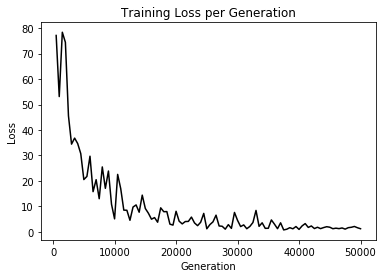

In [83]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()